# Hands-On 1: Audio Feature Extraction

For this first hands-on session, we are going to investigate the extraction of audio features. This is the first step for designing a classification model (in future hands-on sessions). <br>
As the recording of audio signals using a microphone will also be covered in a future hands-on session, we will start here by using sounds that we recorded for you. They have been placed in the `soundfiles` subdirectory.

To ensure you are catching the content of this notebook, we leave you with an infinitesimal amount of **code to write**. 

You will find the zones to be briefly filled  with a `### TO COMPLETE` in the cells below.

This first cell imports the required libraries.
We use uv to manage the libraries, some are common ones downloaded while other are custom ones available in `classification/src`.
If that cell doesn't run properly, it probably isn't run with the correct kernel, maybe linked to a wrong uv installation.

In [35]:
import librosa  # For audio signal computations as MFCC
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
import soundfile as sf
from scipy import signal

from src.classification.datasets import Dataset, get_cls_from_path
from src.classification.utils.plots import plot_audio, plot_specgram

We then create a matrix with path names of height H=5 classes and W=20 sounds per class. This will give you simple access to any sound from the dataset.

In [36]:
dataset = Dataset()

print("\n".join(dataset.list_classes()))

background
birds
chainsaw
fire
fireworks
gunshot
handsaw
helicopter


You can now select a sound from a given class using ``dataset[class_name, sound_index]``. For example, the third sound of the ``birds`` class is accessed with ``dataset["birds", 2]`` and the following cell plays the sound:

In [37]:
sound = dataset["birds", 2]
x, fs = sf.read(sound)
target_dB = 25
x /= np.linalg.norm(x) * 10 ** (-target_dB / 20)
print(f'Playing "{get_cls_from_path(sound)}"')

# If you have no sound, try to uncomment the following to change audio output
# print(sd.query_devices())
# x = ... # Audio output id to use
# sd.default.device = [1,x]

sd.play(x, fs)

Playing "birds"


We now ask you to complete the cells below.

## 1) Resampling and filtering

Most probably your circuit board will sample the analog audio signal at a frequency $f_s = 11025$ Hz. <br>
However, the audio provided in the dataset are sampled with $f_s = 44100$ Hz, you should thus downsample each audio signal to keep coherency with your real setup. There are 2 solutions:
- Rewrite a new dataset with the downsampled audio signals.
- Downsample each audio which is read.

We provide you with the second one.

***
#### <u> The following derivations are not necessary for the rest of this notebook, but are still provided for the curious students... </u>

Let us consider one original audio signal from the dataset and denote it $x[n]$, for $n=0,\dots,N-1$.

The downsampled signal $y$ can be written as 

$$
    y[m] = w[mM],\quad \text{with}\ w[k] = (h \ast x)[k] = \sum_{n=-\infty}^{\infty} h[n]x[k-n],
$$

where $h$ is a discrete low-pass filter and $M$ is the downsampling factor, here $M=4$. <br>

We can expand both $y$ and $w$ according to their Fourier series (DTFT) $Y$ and $W$, respectively, so that:

$$
    y[m] = \frac{1}{2\pi} \int_0^{2\pi} Y(e^{j\Omega}) e^{jm\Omega} d\Omega \tag{1}
$$
$$
    w[mM] = \frac{1}{2\pi} \int_{0}^{2\pi} W(e^{j\Omega}) e^{jmM\Omega} d\Omega = \frac{1}{2\pi} \sum_{k=0}^{M-1} \int_{2\pi k/M}^{2\pi(k+1)/M} W(e^{j\Omega}) e^{jmM\Omega} d\Omega \tag{2}
    $$

Regarding $w$, applying the change of variable $\Omega \leftarrow \Omega-2\pi k/M$ to each integral of the sum, and changing $k \leftarrow M - k$, we can further write

$$
   \textstyle w[mM] = \frac{1}{2\pi} \int_0^{2\pi/M} \sum_{k=0}^{M-1} W[e^{j(\Omega - 2\pi k/M)}] e^{jmM\Omega} d\Omega.
$$


With a final change of variable $\Omega \leftarrow M\Omega$, we get
$$
    \textstyle w[mM] = \frac{1}{2\pi} \int_0^{2\pi} \frac{1}{M} \sum_{k=0}^{M-1} W[e^{j(\Omega - 2\pi k)/M}] e^{jm\Omega} d\Omega.
$$

And by identifying (1) and (2), this yields:
$$
    Y(e^{j\Omega}) = \frac{1}{M} \sum_{k=0}^{M-1} W[e^{j(\Omega -2\pi k)/M}]
$$

***

In practice, here is the observed phenomenon when downsampling the spectrum above with factor $M=2$.

<center> <img src="figs/downsampling.png" alt=""  width="600" height="300"/> </center>

Playing and showing data for :  birds
Downsampling factor:  4


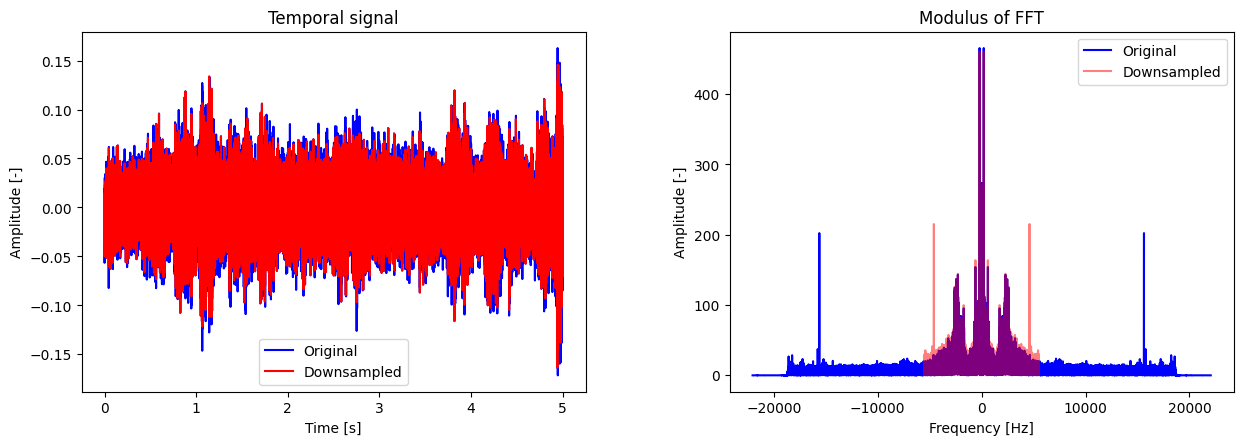

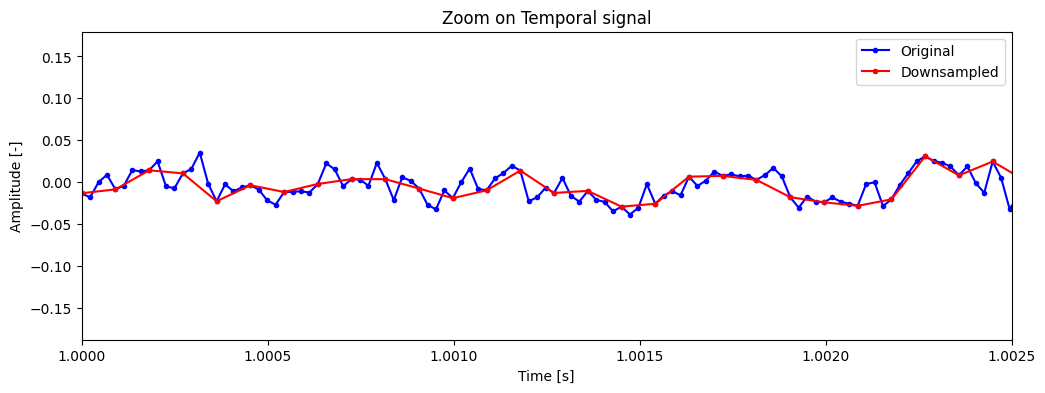

In [38]:
from sklearn.utils import resample


fs_down = 11025  # Target sampling frequency
sound = dataset["birds", 2]  # Sound choice

print("Playing and showing data for : ", get_cls_from_path(sound))
x, fs = sf.read(sound)


M = fs // fs_down  # Downsampling factor
print("Downsampling factor: ", M)



### TO COMPLETE
### Downsample "audio"

# x_naive_down, T = librosa.load(sound, sr=fs_down)  # Naive downsampling using librosa

x_naive_down = x[::M]

### DONE



plot_audio(x, x_naive_down, fs, fs_down)  # Function call

Is your downsampling working properly? What can you observe on the spectrum of the downsampled signal? How is this phenomenon named and what is its origin?

In order to avoid it, the original signal should be low-pass filtered prior to downsampling (as presented in the mathematics above).

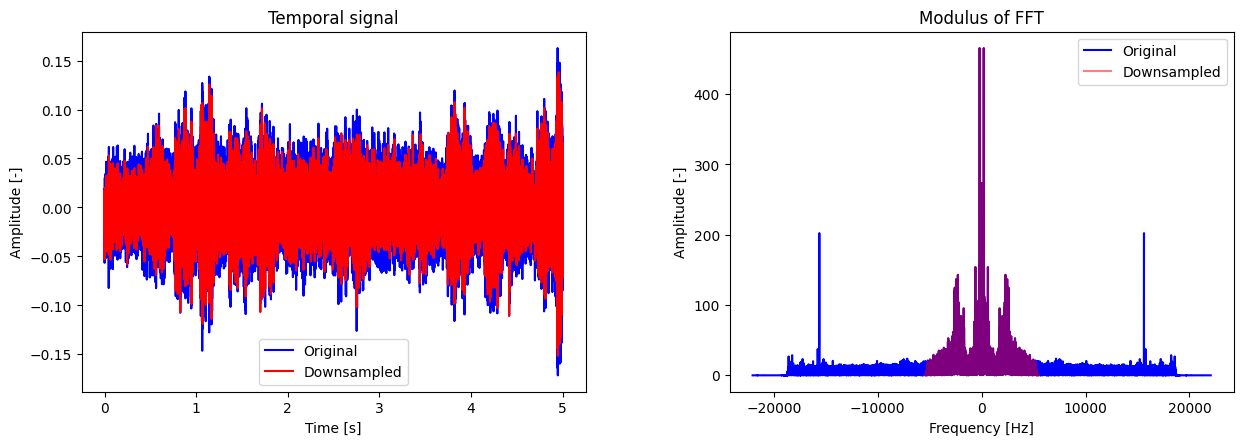

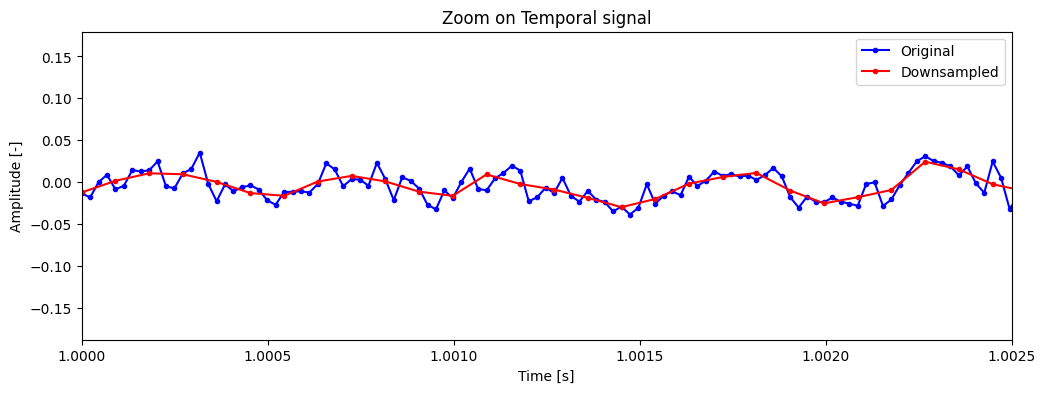

In [39]:
"Low-pass filtering before downsampling"
N = 100  # number of taps
taps = signal.firwin(numtaps=N, cutoff=fs_down / 2, window="hamming", fs=fs)
x_filt = np.convolve(x, taps, mode="full")

### TO COMPLETE
### Downsample ``audio_filt``
x_filt_down, T = librosa.load(sound, sr=fs_down)

### DONE

plot_audio(x, x_filt_down, fs, fs_down)

The obtained spectrum of the downsampled signal should not suffer from aliasing anymore. In fact, there is a built-in function in ``scipy.signal`` that performs the downsampling, including a low-pass filter: ``scipy.signal.resample``. Its docstring is:

In [40]:
help(signal.resample)

Help on function resample in module scipy.signal._signaltools:

resample(x, num, t=None, axis=0, window=None, domain='time')
    Resample `x` to `num` samples using Fourier method along the given axis.
    
    The resampled signal starts at the same value as `x` but is sampled
    with a spacing of ``len(x) / num * (spacing of x)``.  Because a
    Fourier method is used, the signal is assumed to be periodic.
    
    Parameters
    ----------
    x : array_like
        The data to be resampled.
    num : int
        The number of samples in the resampled signal.
    t : array_like, optional
        If `t` is given, it is assumed to be the equally spaced sample
        positions associated with the signal data in `x`.
    axis : int, optional
        The axis of `x` that is resampled.  Default is 0.
    window : array_like, callable, string, float, or tuple, optional
        Specifies the window applied to the signal in the Fourier
        domain.  See below for details.
    domain : s

In the following, we use this function.

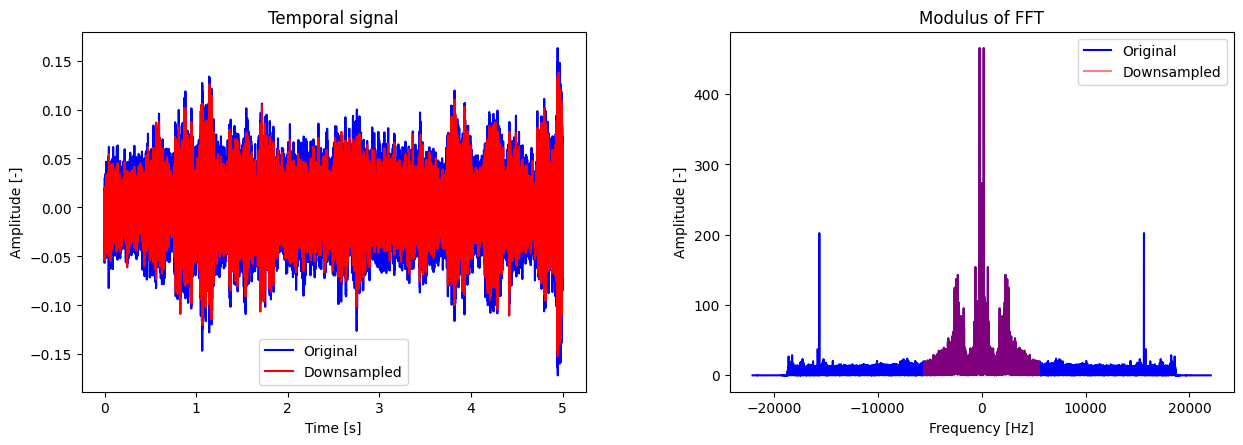

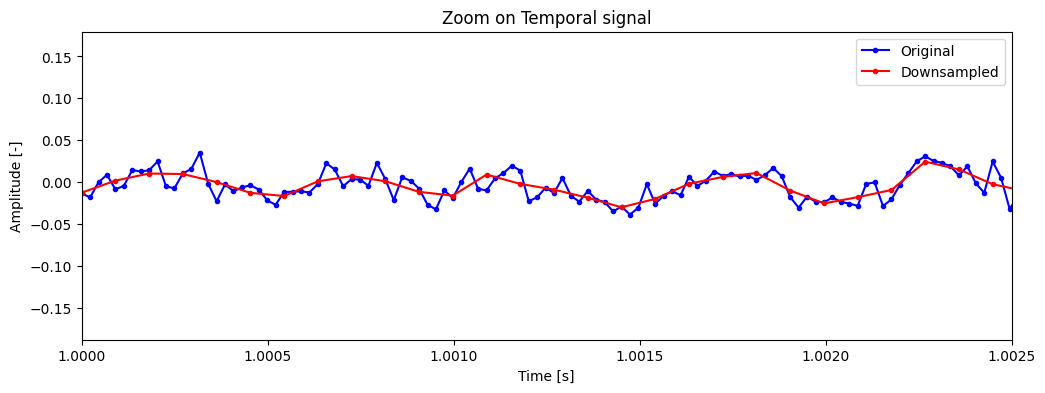

In [41]:
y = signal.resample(x, int(len(x) / M))
L = len(y)

plot_audio(x, y, fs, fs_down)

Can you hear the differences between the downsampled versions of the audio signal and the original one?
Nathan: First one: no differences, normal we play the same sound ; Second: Big difference, low frequency (noise?) has higher intensity and we hear less the birds ; Third and fourth: (j'entends pas trop de différence ? on entend peut être plus clairement les oiseaux mais je suis pas trop sûr de ce qu'on est supposé observer...)

In [42]:
target_dB = 25
x /= np.linalg.norm(x) * 10 ** (-target_dB / 20)
sd.play(x, fs, blocksize=1024)
# sd.play(x_naive_down, fs_down, blocksize=1024)
# sd.play(x_filt_down, fs_down, blocksize=1024)
# sd.play(y, fs_down, blocksize=1024)

You can also try sounds from different classes by running again the code above and changing the choice of the variable ``sound``. Maybe you will notice there are two *original* and two *downsampled* signals shown. Can you guess why you have two signals? How to deal with this?

Now that we are working with sound signals with the same sampling frequency as for the project, we can go on.

## 2) Windowing and spectrogram computation

A very intuitive way to represent an audio signal is with a time-frequency analysis. 
The spectrogram of a signal consists in applying an FFT on successive subpieces of it, and thus obtaining a spectral content evolving with time.

Find an illustration of the idea here below.

<center> <img src="figs/sound2fv.svg" alt="" height="500"/> </center>

Note: You can eventually add a "+1" in the "np.log" to get positive dB. This will look differently.


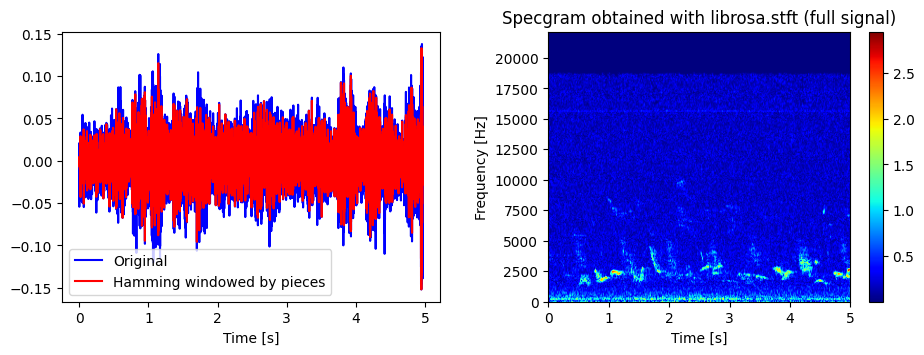

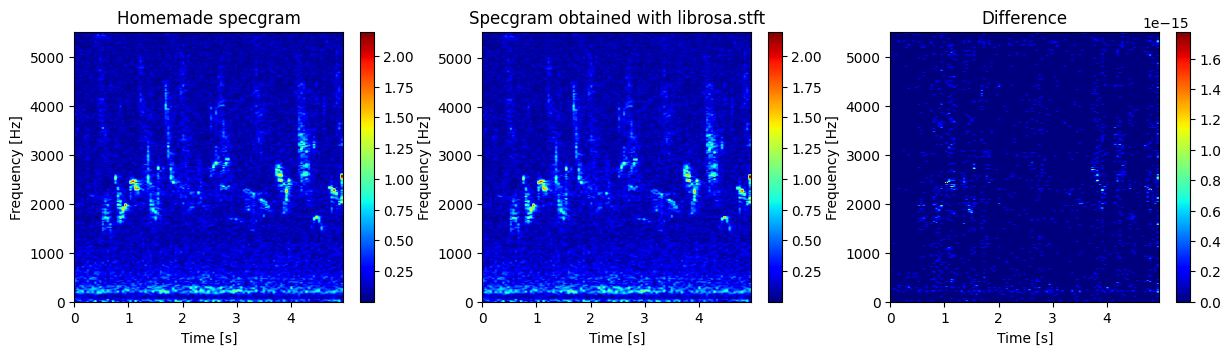

In [43]:
Nft = 512  # Number of samples by FFT

# Homemade computation of stft
"Crop the signal such that its length is a multiple of Nft"
y = y[: L - L % Nft]
L = len(y)
"Reshape the signal with a piece for each row"
audiomat = np.reshape(y, (L // Nft, Nft))
audioham = audiomat * np.hamming(Nft)  # Windowing. Hamming, Hanning, Blackman,..
z = np.reshape(audioham, -1)  # y windowed by pieces
"FFT row by row"
stft = np.fft.fft(audioham, axis=1)
stft = np.abs(
    stft[:, : Nft // 2].T
)  # Taking only positive frequencies and computing the magnitude

"Library Librosa computing stft"
stft2 = librosa.stft(
    x, n_fft=Nft, hop_length=Nft, window="hamm", center="False"
)  # without downsampling the signal
stft4 = np.abs(librosa.stft(z, n_fft=Nft, hop_length=Nft, window="rect", center=False))

print(
    'Note: You can eventually add a "+1" in the "np.log" to get positive dB. This will look differently.'
)

"Plots"
fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_axes([0.0, 0.0, 0.42, 0.9])
ax2 = fig.add_axes([0.54, 0.0, 0.42, 0.9])

ax1.plot(np.arange(L) / fs_down, y, "b", label="Original")
ax1.plot(np.arange(L) / fs_down, z, "r", label="Hamming windowed by pieces")
ax1.set_xlabel("Time [s]")
ax1.legend()

plot_specgram(
    np.log(1+np.abs(stft2)),
    ax2,
    title="Specgram obtained with librosa.stft (full signal)",
    tf=len(x) / fs,
)
plt.show()

"Comparing the spectrograms"
fig2 = plt.figure(figsize=(12, 3))
ax3 = fig2.add_axes([0.0, 0.0, 0.28, 0.9])
ax4 = fig2.add_axes([0.34, 0.0, 0.28, 0.9])
ax5 = fig2.add_axes([0.68, 0.0, 0.28, 0.9])
plot_specgram(np.log(1+np.abs(stft)), ax3, title="Homemade specgram", tf=len(y) / fs_down)
plot_specgram(
    np.log(1+np.abs(stft4)),
    ax4,
    title="Specgram obtained with librosa.stft",
    tf=len(y) / fs_down,
)
plot_specgram(
    np.log(1+np.abs(stft - stft4[:-1, :])), ax5, title="Difference", tf=len(y) / fs_down
)
plt.show()

What differences can you notice between the upper spectrogram and the two others at the bottom?

Nathan: The upper one is the one we obtain without downsampling, the bottom one are obtain with the downsample signal (one is homemade, but the difference ain't big so who cares?)

Nathan: we don't really lose much by downsampling so its nice ? (l'échelle en haut est plus grande mais en zoomant on aurait à peu près la même qu'en bas je pense)

<u> Remark:</u> The motivation for having a homemade version of the spectrogram is that in practice these computations will be embedded in the Nucleo board (the transmitter) and coded in C with fixed-point representation. Thus, as your classification model will be trained on feature vectors computed in Python but evaluated on feature vectors computed in C, it's crucial to know what are the exact steps followed for the signal transformation, to have these steps implementable in C, and to ensure they are the same.

## 3) From Hz to Melspectrogram

Now we have done the major part of the job. But recall that this information will have to be transmitted wirelessly from your circuit board (transmitter) to a base station (receiver). It is thus good practive to try synthetizing a bit the content of this spectrogram. <br>

A popular approach is to transform the frequency axis from Hz to Mel unit. The intuition behind this transformation is that the human ear will more easily distinguish between $100$ and $200$ Hz than between $3000$ and $3100$ Hz. So higher frequencies are more likely to be put together in very fewer coefficients. <br>

This last step will thus consist in replacing each column of the spectrogram ``stft`` with size $N_{FT}$ by a shorter column with size $N_{mel} \ll N_{FT}$. To do so, we will use an Hz to Mel (``Hz2Mel``) transformation matrix provided by ``librosa``, and apply a matrix multiplication for each column.

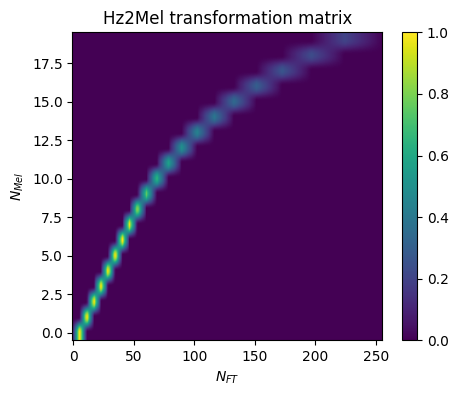

In [44]:
Nmel = 20

"Obtain the Hz2Mel transformation matrix"
mels = librosa.filters.mel(sr=fs_down, n_fft=Nft, n_mels=Nmel)
mels = mels[:, :-1]

### TO COMPLETE
### Normalize the mels matrix such that its maximum value is one.
melsMax = np.max(mels)
melsMin = np.min(mels)
mels = (mels - melsMin) / (melsMax - melsMin)

### DONE

"Plot"
plt.figure(figsize=(5, 4))
plt.imshow(mels, aspect="auto", origin="lower")
plt.colorbar()
plt.title("Hz2Mel transformation matrix")
plt.xlabel("$N_{FT}$")
plt.ylabel("$N_{Mel}$")
plt.show()

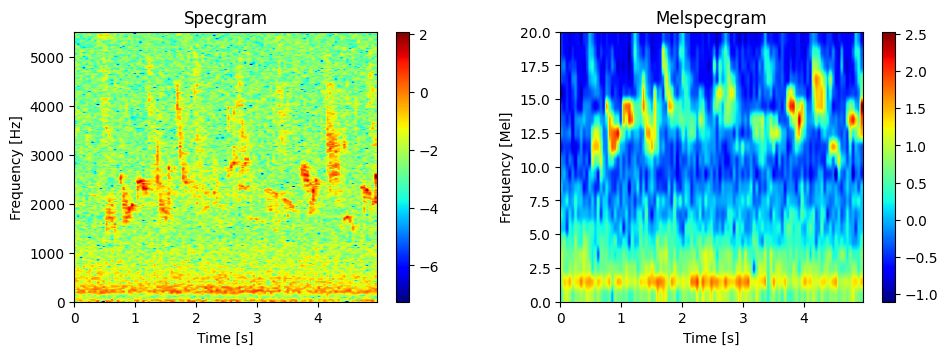

44100


In [45]:
"Melspectrogram computation"
### TO COMPLETE
###  Perform the matrix multiplication between the Hz2Mel matrix and stft.
melspec = mels @ stft

"Plot"
fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_axes([0.0, 0.0, 0.42, 0.9])
ax2 = fig.add_axes([0.54, 0.0, 0.42, 0.9])
plot_specgram(np.log(np.abs(stft)), ax=ax1, title="Specgram", tf=len(y) / fs_down)
plot_specgram(
    np.log(np.abs(melspec)),
    ax=ax2,
    is_mel=True,
    title="Melspecgram",
    tf=len(y) / fs_down,
)
plt.show()

print(fs)

Do these two spectrogram look similar? :) <br> 
What is the gain in the number of coefficients?

## 4) Creating black boxes

Now you have seen how to make the computations. <br>
A universal procedure consists in writing functions that will serve as working blocks and hide the computation details.
We can then gradually increase the abstraction. <br>

As any programmer should do, you are strongly encourage to ``fill your functions with a clear and concise docstring``. This will help you later this year when you will want to make improvements to some parts of your code. <br>

**Remark**: In any hands-on session you will work on during this semester, you will be provided with some already implemented code to exploit for processing and visualisation.
The implemented code will sometimes have been written by the teaching staff in the most readable and modular way possible. However, this may happen you want to add some features or simply modify some functions. Feel free to do so. In general, you can modify anything as you wish. Even the Python packages!

In [ ]:
def resample(x, M=4):
    """
    Downsample a signal by an integer factor M (naive decimation).

    Args:
    ----
    x : np.ndarray
        Input audio signal.
    M : int, optional
        Downsampling factor. Default = 4.

    Returns:
    -------
    y : np.ndarray
        Downsampled signal.
    """
    return signal.resample(x, int(len(x)/M))


def specgram(y, Nft=512):
    """
    Compute the magnitude spectrogram (STFT) of a signal.

    Args:
    ----
    y : np.ndarray
        Input audio signal.
    Nft : int, optional
        FFT window size. Default = 512.

    Returns:
    -------
    stft : np.ndarray
        Spectrogram (magnitude of STFT).
    """
    # Crop the signal length to a multiple of Nft
    L = len(y) - (len(y) % Nft)
    y = y[:L]

    # Reshape into frames
    frames = np.reshape(y, (L // Nft, Nft))

    # Apply Hamming window
    frames_win = frames * np.hamming(Nft)
    
    # Compute FFT row by row
    stft = np.fft.fft(frames_win, axis=1)

    # Keep only positive frequencies and magnitude
    stft = np.abs(stft[:, : Nft // 2].T)

    return stft


def melspecgram(x, Nmel=20, Nft=512, fs=44100, fs_down=11025):
    """
    Compute the Mel spectrogram of a signal.

    Args:
    ----
    x : np.ndarray
        Input audio signal.
    Nmel : int, optional
        Number of Mel bands. Default = 20.
    Nft : int, optional
        FFT window size. Default = 512.
    fs : int, optional
        Original sampling frequency. Default = 44100.
    fs_down : int, optional
        Target (downsampled) sampling frequency. Default = 11025.

    Returns:
    -------
    melspec : np.ndarray
        Mel spectrogram.
    """
    # Downsampling factor
    M = fs // fs_down
    y = resample(x, M)

    # Spectrogram
    stft = specgram(y, Nft=Nft)

    # Mel filter bank
    mels = librosa.filters.mel(sr=fs_down, n_fft=Nft, n_mels=Nmel)
    mels = mels[:, :-1]  # adjust dimensions

    # Normalize to [0, 1]
    mels = mels / np.max(mels)

    # Apply transformation
    melspec = mels @ stft

    return melspec

## 5) Show us your skills
You are now encouraged to apply the functions you created above to sounds from at least 3 different classes. Observe their spectrograms and comment. Is it easy to differentiate sounds from the classes you chose?

Note: Notice that here we added the "+1" for the visualization!


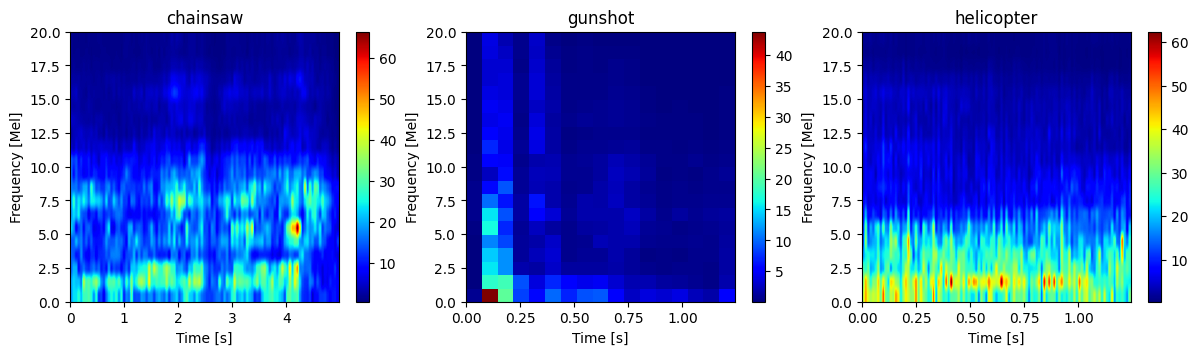

In [ ]:
### TO COMPLETE
### Choose 3 sounds from different classes to observe how their mel spectrograms differ

# background
# birds
# chainsaw
# fire
# fireworks
# gunshot
# handsaw
# helicopter

sound1 = dataset["chainsaw", 5]
sound2 = dataset["gunshot", 10]
sound3 = dataset["helicopter", 15]

"Compute the melspecgrams"
x1, fs_down = sf.read(sound1)
x2, fs_down = sf.read(sound2)
x3, fs_down = sf.read(sound3)
melspec1 = melspecgram(x1)
melspec2 = melspecgram(x2)
melspec3 = melspecgram(x3)

print('Note: Notice that here we added the "+1" for the visualization!')

"Plot"
fig = plt.figure(figsize=(12, 3))
ax1 = fig.add_axes([0.0, 0.0, 0.28, 0.9])
ax2 = fig.add_axes([0.33, 0.0, 0.28, 0.9])
ax3 = fig.add_axes([0.66, 0.0, 0.28, 0.9])
plot_specgram(
    melspec1, ax=ax1, is_mel=True, title=get_cls_from_path(sound1), tf=len(y) / fs_down
)
plot_specgram(
    melspec2, ax=ax2, is_mel=True, title=get_cls_from_path(sound2), tf=len(y) / fs_down
)
plot_specgram(
    melspec3, ax=ax3, is_mel=True, title=get_cls_from_path(sound3), tf=len(y) / fs_down
)
plt.show()

### Question:
Briefly comment what is intuitive for you in the content of these 3 spectrograms respectively with the corresponding classes.
How can you differentiate them?

In [48]:
### TO COMPLETE
# Answer the questions above